In [1]:
%%bash
# Extract raw data
tar -zxf ../raw_data/20190521.tar.gz -C ../raw_data

In [2]:
%matplotlib inline

# Import packages
import pandas as pd
import datetime as dt
import os

# Import user-defined module with regression and plotting functions
from src.calibrate import *

meas_day = "20190521"
data_directory = "../raw_data/"+meas_day+"/"

# Reformat measurement day to the format that GC uses
dt_day = dt.datetime.strptime(meas_day, "%Y%m%d")
gc_day = dt_day.strftime("%-m%d%Y")

infiles = os.listdir(data_directory)

# First create a pandas dataframe of peak table info from the GC 
# ascii files created during each individual sample run 
df = pd.DataFrame(columns=["sample", "N2O_peak", "CO2_peak", "CH4_peak"])

for file in infiles:
    sample = file # sample name
    peaks = get_peak_info(data_directory+file, CH4_check=0) # tuple of 3 peak areas
    
    df = df.append({"sample": sample, "N2O_peak": peaks[0], 
                                      "CO2_peak": peaks[1], 
                                      "CH4_peak": peaks[2]}, ignore_index=True)

pd.set_option('display.max_rows', 90)
# print(df)

In [3]:
# Create new dataframe with location, date, depth and vial number info
samples = sample_info_from_filename(df, 'sample')

# print(samples)

In [4]:
# Get info from standards
stds = df[df['sample'].str.contains('Std')].copy()

QCfilter = stds['sample'].str.match('QC') # Drop rows that are QC
QC = stds[QCfilter]
stds = stds[~QCfilter]

# Get the std concentration from the sample name
stds['ppm'] = stds['sample'].str.extract(r'Std_(\d+)ppm')
stds['ppm'] = pd.to_numeric(stds['ppm']) # Convert to float

# Correct for N2O Std concentrations less than 1
i = stds.index[stds['sample'].str.match('N2OStd_05')]
stds.loc[i, ['ppm']] = 0.5
i = stds.index[stds['sample'].str.match('N2OStd_0101')]
stds.loc[i, ['ppm']] = 0.101

# Convert peaks to numeric
stds['N2O_peak'] = pd.to_numeric(stds['N2O_peak'])
stds['CO2_peak'] = pd.to_numeric(stds['CO2_peak'])
stds['CH4_peak'] = pd.to_numeric(stds['CH4_peak'])

print(stds)
print(QC)

                            sample  N2O_peak  CO2_peak  CH4_peak      ppm
1     CH4Std_100ppm_5212019_26.txt     37483   1892905    169999    100.0
2      CH4Std_10ppm_5212019_25.txt     30313  10508583     17849     10.0
3       CH4Std_2ppm_5212019_24.txt     45636    549046    648485      2.0
4    CH4Std_5030ppm_5212019_27.txt     29819   1255687   8134798   5030.0
5    CO2Std_1000ppm_5212019_16.txt     89410   2551378      2608   1000.0
6   CO2Std_10100ppm_5212019_17.txt     42195  17510339      4359  10100.0
7    CO2Std_1010ppm_5212019_11.txt     88792   2434974      3127   1010.0
8   CO2Std_50000ppm_5212019_18.txt     37899  71860885      4664  50000.0
9     CO2Std_500ppm_5212019_15.txt     29190   1951299      2717    500.0
12      N2OStd_10ppm_5212019_4.txt    998263    993907      2503     10.0
13      N2OStd_1ppm_5212019_23.txt    397914    151141         0      1.0
14       N2OStd_1ppm_5212019_3.txt    399780    146828         0      1.0
46     N2OStd_05ppm_5212019_31.txt    

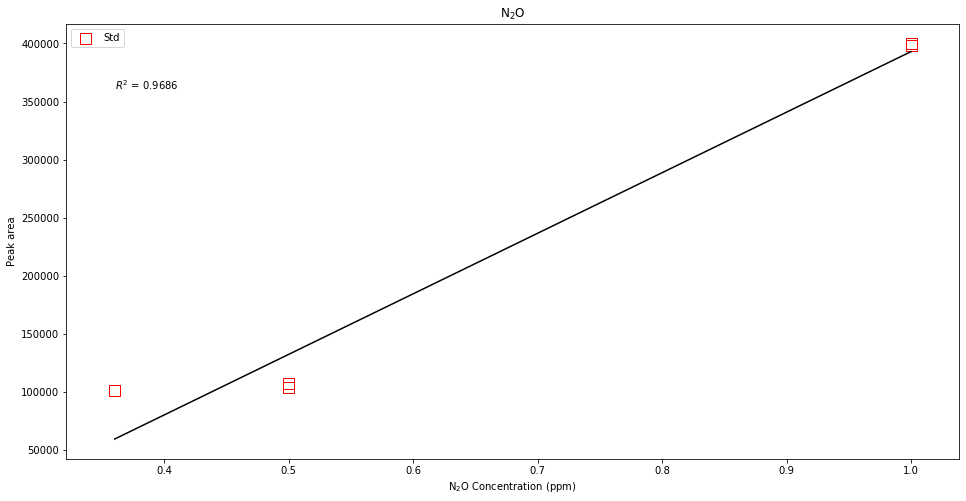

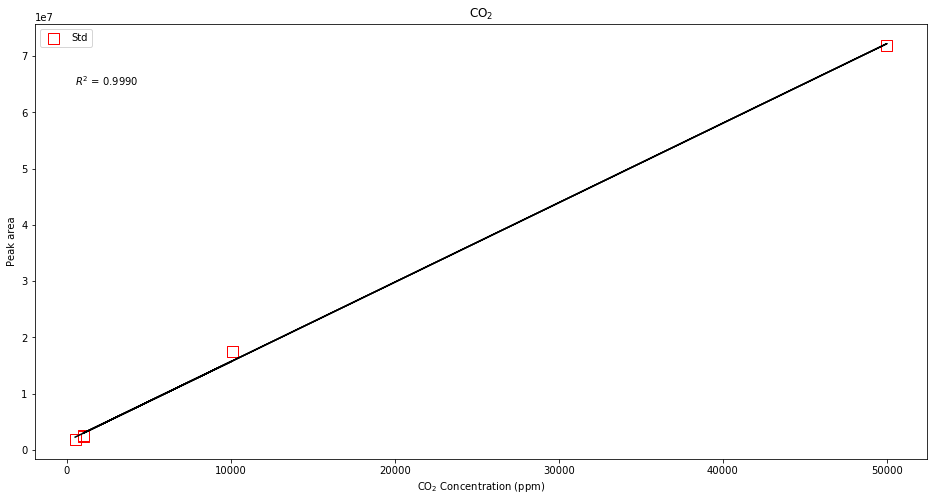

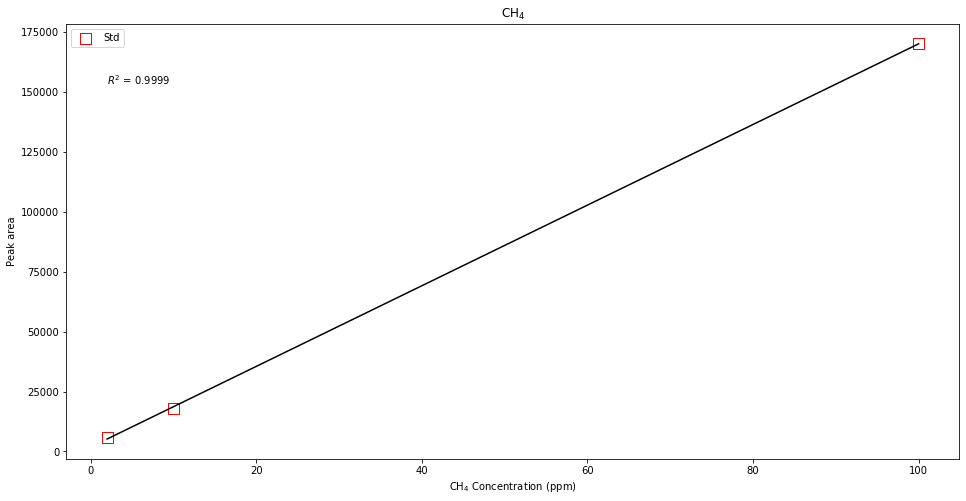

In [6]:
# Separate out N2O, CH4 and CO2 standards
N2Ostd  = stds[stds['sample'].str.contains("N2OStd")].copy()
CO2std  = stds[stds['sample'].str.contains("CO2Std")].copy()
CH4std  = stds[stds['sample'].str.contains("CH4Std")].copy()

# Get index of one QC
i = QC.index[QC['sample'] == 'QC-CH4Std_2ppm-CO2Std_400ppm-N2OStd_036ppm_5212019.txt']

# Play around with CH4 standard curve
# Add in QC 2 and QC 3 only -- QC1 is different from the others, with lower concentrations all around
CH4std = CH4std[~CH4std['sample'].str.contains('5030ppm')] # Drop 5000 ppm since no samples are above 10 ppm
CH4std = CH4std[~CH4std['sample'].str.contains('_2ppm')]
CH4std = CH4std.append({'ppm': 2., 'CH4_peak': QC.loc[i, 'CH4_peak'].values[0]}, ignore_index=True)

# Play around with N2O standard curve 
N2Ostd = N2Ostd[~N2Ostd['sample'].str.contains('_10ppm')] # Drop 10 ppm
N2Ostd = N2Ostd.append({'ppm': 0.36, 'N2O_peak': QC.loc[i, 'N2O_peak'].values[0]}, ignore_index=True)

# Plot the standards with linear regression trendline
plot_standards(N2Ostd['ppm'],N2Ostd['N2O_peak'],r'N$_2$O')
plot_standards(CO2std['ppm'],CO2std['CO2_peak'],r'CO$_2$')
plot_standards(CH4std['ppm'],CH4std['CH4_peak'],r'CH$_4$')

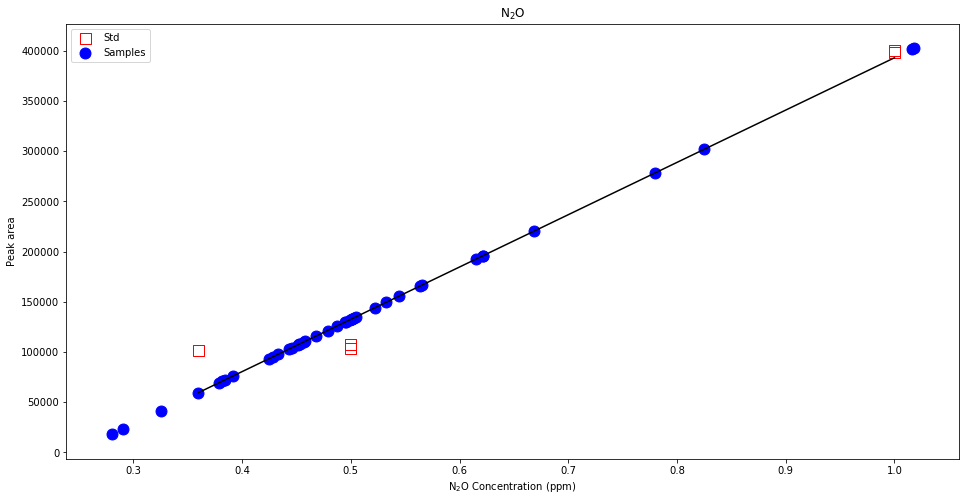

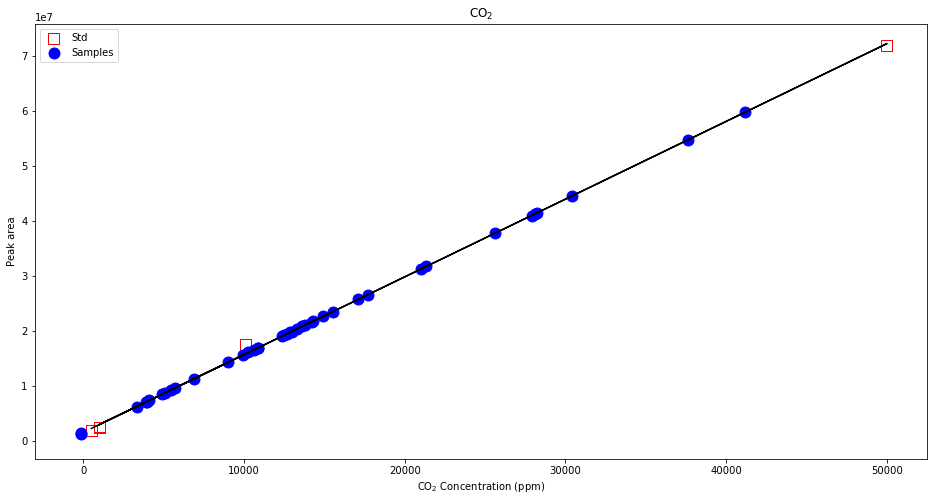

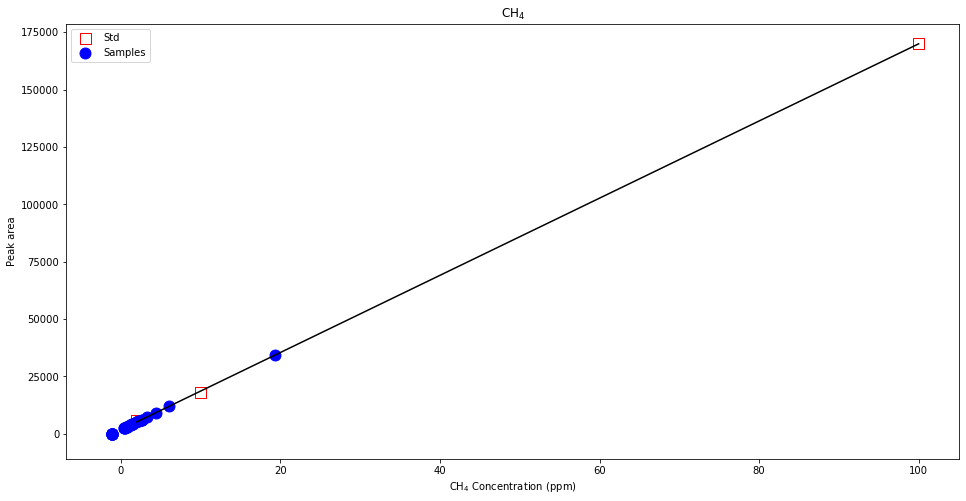

In [7]:
# Now, plot the standards along with the samples
plot_samples(samples['N2O_peak'], N2Ostd['ppm'], N2Ostd['N2O_peak'], r"N$_2$O")
plot_samples(samples['CO2_peak'], CO2std['ppm'], CO2std['CO2_peak'], r"CO$_2$")
plot_samples(samples['CH4_peak'], CH4std['ppm'], CH4std['CH4_peak'], "CH$_4$")

In [8]:
# Since the data look good, export the sample concentrations to a text file
saveoutput = save_sampleconc_new(N2Ostd['ppm'], N2Ostd['N2O_peak'], 
                                 CO2std['ppm'], CO2std['CO2_peak'], 
                                 CH4std['ppm'], CH4std['CH4_peak'], 
                                 samples, "../processed_data/RVT_TracerTest_GasConcentrations_20190521.txt", 
                                 write_to_datafile=True)
print(saveoutput)

   vial    location depth       date method    dup  N2O_conc  N2O_bdl  \
10   28  Atmosphere     0 2019-03-27      G  False  0.384168    False   
11   29  Atmosphere     0 2019-04-23      G  False  0.379070    False   
18    6        PTC1   030 2019-04-23      G  False  0.499027    False   
19    6        PTC1   060 2019-03-27      G  False  0.779323    False   
20    7        PTC1   060 2019-04-23      G  False  0.532820    False   
21    7        PTC1   090 2019-03-27      G  False  1.017835    False   
22    8        PTC1   090 2019-04-23      G  False  0.495046    False   
23    8        PTC1   120 2019-03-27      H  False  1.016251    False   
24    9        PTC1   120 2019-04-23      G  False  0.824928    False   
25    9        PTC1   150 2019-03-27      H  False  0.180000     True   
26   10        PTC1   150 2019-04-23      H  False  0.180000     True   
27   10        PTC2   030 2019-03-27      G  False  0.424923    False   
28   11        PTC2   060 2019-03-27      G  False 